<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métricas

Consideraremos tiempos de ejecución para distintos tamaños y redes en el SIR markoviano.
Además, comparamos gráficamente trayectorias markovianas con ambos algoritmos, es decir, utilizando el algoritmo para redes markovianas, y el algoritmo para redes no markovianas, usando distribuciones exponenciales y cercanas a una exponencial, de la familia Weibull.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [4]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index


In [10]:
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia

#### Red Poisson $N=5\cdot 10^3$, con media $n=N\cdot 0.1$.
#### $\beta=1.25$, $\gamma=1$
#### Condición inicial $X(0)=(N-1,1,0)$

--- 63.5496940612793 Segundos para crear la gráfica ---
Empieza


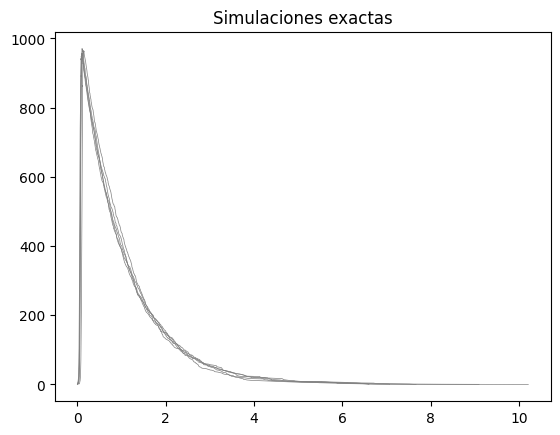

--- 4.094378709793091 Segundos para ejecutar ---
--- 67.64523077011108 Segundos en total ---


In [16]:
import time
start_time = time.time()
N=10**3
n=int(N*0.1)
X_I_0=1
ksum=1
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))



#### Red Binomial $N=10^3$, con paámetro $p=0.1$.
#### $\beta=1.25$, $\gamma=1$
#### Condición inicial $X(0)=(N-1,1,0)$

--- 20.16082262992859 Segundos para crear la gráfica ---
Empieza
--- 78.66382002830505 Segundos para ejecutar 1 iteracion ---
--- 86.21764707565308 Segundos para ejecutar 1 iteracion ---
--- 83.84100842475891 Segundos para ejecutar 1 iteracion ---
--- 86.09617829322815 Segundos para ejecutar 1 iteracion ---
--- 85.02950119972229 Segundos para ejecutar 1 iteracion ---


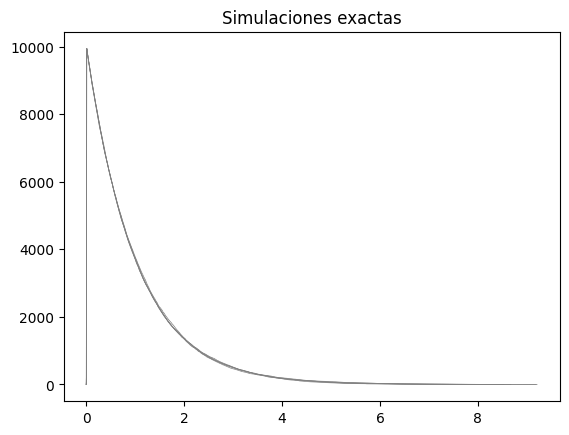

--- 607.3817899227142 Segundos para ejecutar ---
--- 627.543778181076 Segundos en total ---


In [20]:
import time
start_time = time.time()
N=10**4
n=int(N*0.1)
X_I_0=1
G=nx.fast_gnp_random_graph(N,p=0.1)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))

Mismo algoritmo, pero removiendo vértices

--- 16.882884979248047 Segundos para crear la gráfica ---
Empieza
--- 84.36275863647461 Segundos para ejecutar 1 iteracion ---
--- 83.68527507781982 Segundos para ejecutar 1 iteracion ---
--- 82.46456623077393 Segundos para ejecutar 1 iteracion ---
--- 85.05274486541748 Segundos para ejecutar 1 iteracion ---
--- 84.21597003936768 Segundos para ejecutar 1 iteracion ---


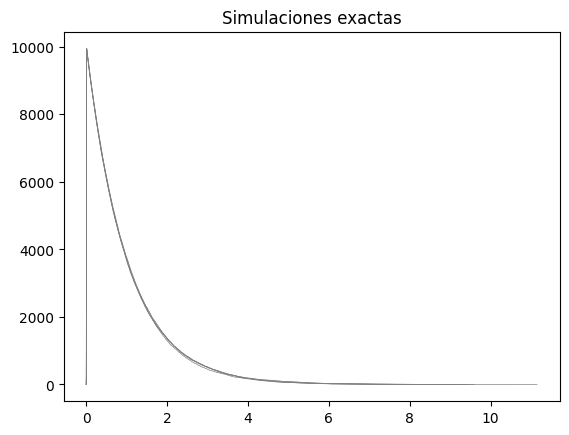

--- 599.3120279312134 Segundos para ejecutar ---
--- 616.1962261199951 Segundos en total ---


In [21]:
def Gillespie_Direct_Method_Network_2(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
            G_network_initial.remove_node(i)
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0):
            flag=False
    return Historia
import time
start_time = time.time()
N=10**4
n=int(N*0.1)
X_I_0=1
G=nx.fast_gnp_random_graph(N,p=0.1)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=np.random.choice(N,size=X_I_0,replace=False).tolist()
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
S_0=N-X_I_0
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    while(len(H)<20):
        H=Gillespie_Direct_Method_Network_2(beta=beta,gamma=gamma,N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))    
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()
print("--- %s Segundos para ejecutar ---" % (time.time() - graph_time))
print("--- %s Segundos en total ---" % (time.time() - start_time))